# Desafio Neurotech

- Vaga: Analista de Dados II (Engenharia)
- Candidato: Douglas de Farias Medeiros
- Desafio: Orquestração e Análise dos Dados de IPTU do Recife
- Objetivo deste notebook: Realizar a análise dos dados após a ingestão, transformação e refinamento

In [0]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, ArrayType, TimestampType
from pyspark.sql.functions import regexp_replace, col, trim, sum, when, to_timestamp, substring, count, lit, round, current_date, months_between, floor, to_date, row_number, desc
from pyspark.sql.window import Window
import re
import matplotlib.pyplot as plt

In [0]:
%run /Workspace/Users/douglasfmedeiros@outlook.com/desafio_neurotech/functions/analise_dados_functions

Vamos inicialmente importar os dados da tabela **DADOS_IPTU** que está na camada gold. Essa tabela possui dados consolidados de IPTU da cidade do Recife para o período compreendido entre 2020 e 2024, proveniente de arquivos nos formatos CSV e JSON. A ingestão desses dados nas camadas bronze, silver e gold foi realizada por meio do notebook *03_ingestao_dados*, executado previamente à análise deste notebook. Caso deseje efetuar uma nova carga dos dados ou ainda não tenha feito isso, descomente o código abaixo, execute-o e aguarde a carga de dados ser realizada até a camada gold.

*Obs.: Antes de executar o comando a seguir, faça o upload dos arquivos CSV e JSON dentro da pasta /Volumes/workspace/default/dados_iptu*

In [0]:
# %run /Workspace/Users/douglasfmedeiros@outlook.com/desafio_neurotech/04_ingestao_dados


Partindo da premissa que os dados foram colocados na pasta indicada e o notebook de ingestão de dados foi executado, vamos seguir com a análise. Vamos ler os dados que foram importados, conforme abaixo:

In [0]:
# Leitura dos dados da tabela unificada
df = spark.read.table('gold_layer.dados_iptu')

# Caso prefira, você também pode importar o arquivo dados_iptu_unificado.csv e executar este notebook de análise diretamente dele, basta comentar o código acima e descomentar o abaixo:
# df = spark.read.csv('dados_iptu_unificado.csv')

A seguir, podemos observar quais colunas temos na tabela que foi lida:

In [0]:
df.columns

['NUMERO_DO_CONTRIBUINTE',
 'ANO_DO_EXERCICIO',
 'DATA_DO_CADASTRAMENTO',
 'TIPO_DE_CONTRIBUINTE',
 'CPFCNPJ_MASCARADO_DO_CONTRIBUINTE',
 'LOGRADOURO',
 'NUMERO',
 'COMPLEMENTO',
 'BAIRRO',
 'CIDADE',
 'ESTADO',
 'FRACAO_IDEAL',
 'AREA_TERRENO',
 'AREA_CONSTRUIDA',
 'AREA_OCUPADA',
 'VALOR_DO_M2_DO_TERRENO',
 'VALOR_DO_M2_DE_CONSTRUCAO',
 'ANO_DA_CONSTRUCAO_CORRIGIDO',
 'QUANTIDADE_DE_PAVIMENTOS',
 'TIPO_DE_USO_DO_IMOVEL',
 'TIPO_DE_PADRAO_DA_CONSTRUCAO',
 'FATOR_DE_OBSOLESCENCIA',
 'ANO_E_MES_DE_INICIO_DA_CONTRIBUICAO',
 'VALOR_TOTAL_DO_IMOVEL_ESTIMADO',
 'VALOR_COBRADO_DE_IPTU',
 'CEP',
 'REGIME_DE_TRIBUTACAO_DO_IPTU',
 'REGIME_DE_TRIBUTACAO_DA_TRSD',
 'TIPO_DE_CONSTRUCAO',
 'TIPO_DE_EMPREENDIMENTO',
 'TIPO_DE_ESTRUTURA',
 'CODIGO_LOGRADOURO']

Inicialmente, vamos investigar o número total de registros da tabela, mesmo que seja com dados duplicados:

In [0]:
# Identificação do número de registros da tabela
total_registros = df.count()
print(f"Total de registros (considerando imóveis duplicados): {total_registros}")

Total de registros (considerando imóveis duplicados): 1600612


## Quantos imóveis há na tabela? 

Para determinar quantos imóveis distintos existem na tabela, será feita uma análise considerando como identificadores únicos os seguintes campos:

- **Logradouro**  
- **Número**  
- **Complemento**  
- **Bairro**  
- **CEP**  
- **Cidade**  
- **Estado**

Cada combinação exclusiva desses valores representa um imóvel único. Ou seja, imóveis com os mesmos dados em todas essas colunas serão considerados duplicatas.

In [0]:
# Colunas que identificam um imóvel
colunas_identificacao = ["LOGRADOURO", "NUMERO", "BAIRRO", "CIDADE", "CEP", "ESTADO", "COMPLEMENTO"]

# Define uma janela de partição por imóvel, ordenando pelo ano mais recente
janela = Window.partitionBy(*colunas_identificacao).orderBy(desc("ANO_DO_EXERCICIO"))

# Adiciona um número de linha para selecionar o registro mais recente por imóvel
df_com_rank = df.withColumn("rank", row_number().over(janela))

# Filtra apenas os registros com rank 1 (ou seja, o mais recente por imóvel)
df_imoveis_unicos = df_com_rank.filter("rank = 1").drop("rank")

# Exibe o resultado
print(f"Total de imóveis únicos: {df_imoveis_unicos.count()}")

Total de imóveis únicos: 400320


A tabela de dados de IPTU possui 400.320 imóveis registrados de maneira única.

## Quais são os principais tipos de uso dos imóveis?

A seguir, podemos visualizar como se dividem os imóveis pelo tipo de uso. Observamos no gráfico que a maioria dos imóveis são destinados para uso residencial, com pouco mais de 330.000 imóveis.

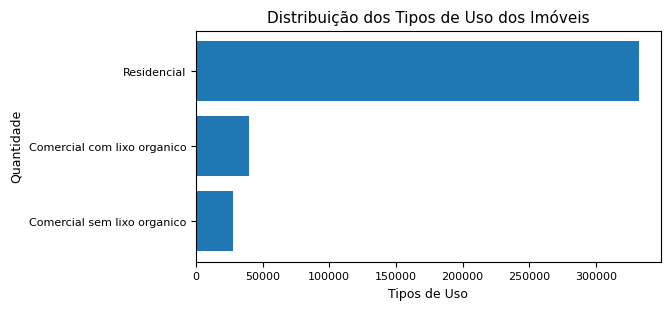

TIPO_DE_USO_DO_IMOVEL,QUANTIDADE
RESIDENCIAL,332160
COMERCIAL COM LIXO ORGANICO,40081
COMERCIAL SEM LIXO ORGANICO,28079


In [0]:
distribuicao_tipo = df_imoveis_unicos.select(*colunas_identificacao, "TIPO_DE_USO_DO_IMOVEL")\
    .groupBy("TIPO_DE_USO_DO_IMOVEL").count().withColumnRenamed('count', 'QUANTIDADE').orderBy("QUANTIDADE", ascending=False)

# Coletar os dados do Spark DataFrame
dados = distribuicao_tipo.select("TIPO_DE_USO_DO_IMOVEL", "QUANTIDADE").orderBy('QUANTIDADE').collect()

# Transformar em listas nativas
tipos = [f"{linha['TIPO_DE_USO_DO_IMOVEL']}" for linha in dados]
tipos = [palavra.capitalize() for palavra in tipos]
quantidades = [linha["QUANTIDADE"] for linha in dados]

plotar_grafico_barra(tipos, quantidades, 'horizontal', 'Distribuição dos Tipos de Uso dos Imóveis', 'Tipos de Uso', 'Quantidade')

distribuicao_tipo.display()

## Em quais bairros temos mais imóveis?

Vamos analisar agora a distribuição dos imóveis por bairro. Como temos muitos bairros, deixamos todos os resultados visíveis na tabela e no gráfico ilustramos apenas os 20 bairros com maior concentração de imóveis na base de dados que está sendo analisada. 

Veja que Boa Viagem possui a maior concentração de imóveis (16,88%), seguido do bairro da Várzea (3,61%) e Boa Vista (3,41%).

In [0]:
# Agrupa por bairro e conta quantos registros únicos há em cada um
distribuicao_bairro = df_imoveis_unicos.groupBy("BAIRRO").count().withColumnRenamed('count', 'QUANTIDADE').orderBy("QUANTIDADE", ascending=False)

total = distribuicao_bairro.selectExpr("sum(QUANTIDADE) as total").collect()[0]["total"]

distribuicao_bairro = distribuicao_bairro.withColumn(
    "% DO TOTAL",
    round((col("QUANTIDADE") / lit(total)) * 100, 2)
)

# Exibe o resultado
distribuicao_bairro.display()

BAIRRO,QUANTIDADE,% DO TOTAL
BOA VIAGEM,67566,16.88
VARZEA,14432,3.61
BOA VISTA,13669,3.41
IMBIRIBEIRA,13528,3.38
CASA AMARELA,13465,3.36
PINA,11696,2.92
CORDEIRO,11588,2.89
MADALENA,11357,2.84
GRACAS,11069,2.77
IPUTINGA,10324,2.58


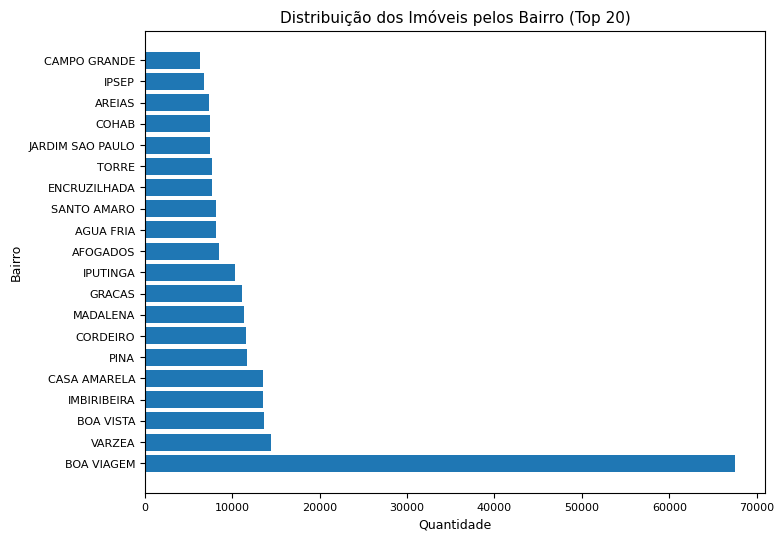

In [0]:
dados = distribuicao_bairro.collect()[:20]

bairros = [linha['BAIRRO'] for linha in dados]
contagens = [linha['QUANTIDADE'] for linha in dados]

plotar_grafico_barra(bairros, contagens, 'horizontal', 'Distribuição dos Imóveis pelos Bairro (Top 20)', 'Quantidade', 'Bairro', 8, 6)

Na tabela abaixo, temos uma abertura cruzada dos dados por bairro e por tipo de uso do imóvel. Perceba que na grande maioria dos bairros os imóveis residenciais dominam, porém, temos alguns bairros em que temos mais imóveis comerciais, como, por exemplo, Paissandu e o bairro do Recife, na região central da cidade.

In [0]:
distribuicao_bairro_tipo_uso = df_imoveis_unicos.select(*colunas_identificacao, "TIPO_DE_USO_DO_IMOVEL")\
    .groupBy("BAIRRO", "TIPO_DE_USO_DO_IMOVEL").count()\
    .withColumnRenamed('count', 'QUANTIDADE')\
    .orderBy(col("BAIRRO").asc(), col("QUANTIDADE").desc())

distribuicao_bairro_tipo_uso.display()

BAIRRO,TIPO_DE_USO_DO_IMOVEL,QUANTIDADE
AFLITOS,RESIDENCIAL,2211
AFLITOS,COMERCIAL COM LIXO ORGANICO,274
AFLITOS,COMERCIAL SEM LIXO ORGANICO,147
AFOGADOS,RESIDENCIAL,6972
AFOGADOS,COMERCIAL COM LIXO ORGANICO,1018
AFOGADOS,COMERCIAL SEM LIXO ORGANICO,511
AGUA FRIA,RESIDENCIAL,7554
AGUA FRIA,COMERCIAL COM LIXO ORGANICO,440
AGUA FRIA,COMERCIAL SEM LIXO ORGANICO,164
ALTO DO MANDU,RESIDENCIAL,988


## Como os imóveis estão distribuídos por tipo de estrutura?

Observe no gráfico abaixo que as construções de concreto aparecem em maior quantidade, seguido das de alvenaria.

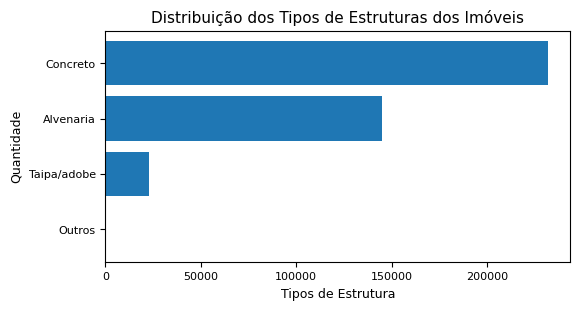

TIPO_DE_ESTRUTURA,QUANTIDADE
Concreto,232131
Alvenaria,145166
Taipa/adobe,22816
Outros,207


In [0]:
tipo_estrutura = df_imoveis_unicos.select(*colunas_identificacao, "TIPO_DE_ESTRUTURA")\
    .groupBy("TIPO_DE_ESTRUTURA").count().withColumnRenamed('count', 'QUANTIDADE').orderBy("QUANTIDADE", ascending=False)

# Coletar os dados do Spark DataFrame
dados = tipo_estrutura.select("TIPO_DE_ESTRUTURA", "QUANTIDADE").orderBy('QUANTIDADE').collect()

# Transformar em listas nativas
tipos = [f"{linha['TIPO_DE_ESTRUTURA']}" for linha in dados]
tipos = [palavra.capitalize() for palavra in tipos]
quantidades = [linha["QUANTIDADE"] for linha in dados]

plotar_grafico_barra(tipos, quantidades, 'horizontal', 'Distribuição dos Tipos de Estruturas dos Imóveis', 'Tipos de Estrutura', 'Quantidade')

tipo_estrutura.display()

## Quais são os principais tipos de imóveis?

Veja no gráfico abaixo que os apartamentos dominam entre os tipos de imóveis, seguidos das casas e lojas comerciais.

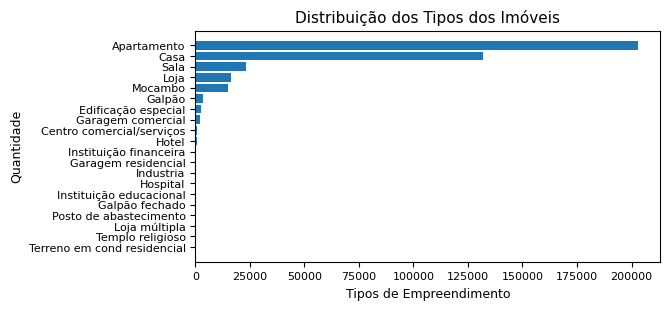

In [0]:
# Agrupa por bairro e conta quantos registros únicos há em cada um
tipo_empreendimento = df_imoveis_unicos.groupBy("TIPO_DE_EMPREENDIMENTO").count().withColumnRenamed('count', 'QUANTIDADE').orderBy("count", ascending=False)

# Coletar os dados do Spark DataFrame
dados = tipo_empreendimento.select("TIPO_DE_EMPREENDIMENTO", "QUANTIDADE").orderBy('QUANTIDADE').collect()

# Transformar em listas nativas
tipos = [f"{linha['TIPO_DE_EMPREENDIMENTO']}" for linha in dados]
tipos = [palavra.capitalize() for palavra in tipos]
quantidades = [linha["QUANTIDADE"] for linha in dados]

plotar_grafico_barra(tipos, quantidades, 'horizontal', 'Distribuição dos Tipos dos Imóveis', 'Tipos de Empreendimento', 'Quantidade')

## Como o inventário está distribuído em termos de idade de construção?

Para realizar esta análise, foram criadas faixas etárias dos imóveis dividindo-o em grupos. Diante disso, percebemos que temos mais imóveis na deixa entre 41-60 anos, seguido da faixa entre 21-40 anos.

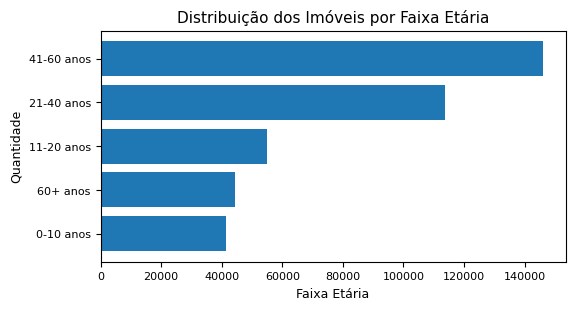

In [0]:
# Converte a string MES_ANO_INICIO_CONTRIBUICAO para data (assumindo dia 01 como padrão)
df_com_data = df_imoveis_unicos.withColumn("DATA_INICIO", to_date(col("ANO_E_MES_DE_INICIO_DA_CONTRIBUICAO").cast('double').cast('integer').cast('string'), "yyyyMM"))

# Calcula a idade em anos com base na data atual
df_com_idade = df_com_data.withColumn("IDADE_IMOVEL",
    floor(months_between(current_date(), col("DATA_INICIO")) / 12)
)

# Cria faixas etárias
df_imoveis_unicos = df_com_idade.withColumn("FAIXA_ETARIA_IMOVEL",
    when(col("IDADE_IMOVEL") <= 10, "0-10 anos")
    .when((col("IDADE_IMOVEL") > 10) & (col("IDADE_IMOVEL") <= 20), "11-20 anos")
    .when((col("IDADE_IMOVEL") > 20) & (col("IDADE_IMOVEL") <= 40), "21-40 anos")
    .when((col("IDADE_IMOVEL") > 40) & (col("IDADE_IMOVEL") <= 60), "41-60 anos")
    .otherwise("60+ anos")
)

# Agrupa por faixa etária e conta os imóveis
distribuicao_idade = df_imoveis_unicos.groupBy("FAIXA_ETARIA_IMOVEL").count().withColumnRenamed('count', 'QUANTIDADE').orderBy("count", ascending=False)

# Coletar os dados do Spark DataFrame
dados = distribuicao_idade.select("FAIXA_ETARIA_IMOVEL", "QUANTIDADE").orderBy('QUANTIDADE').collect()

# Transformar em listas nativas
tipos = [f"{linha['FAIXA_ETARIA_IMOVEL']}" for linha in dados]
tipos = [palavra.capitalize() for palavra in tipos]
quantidades = [linha["QUANTIDADE"] for linha in dados]

plotar_grafico_barra(tipos, quantidades, 'horizontal', 'Distribuição dos Imóveis por Faixa Etária', 'Faixa Etária', 'Quantidade')

## Quais são os bairros mais valiosos?

No gráfico abaixo podemos observar os 5 bairros com maior valor médio dos imóveis, que são: Dois Irmãos, Monteiro, Recife, Jaqueira e Ilha do Retiro, respectivamente. Na tabela abaixo do gráfico ordenada dos valores médios dos imóveis por bairro.



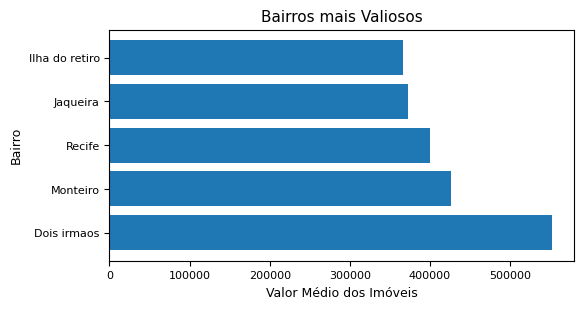

BAIRRO,VALOR_MEDIO_IMOVEL
DOIS IRMAOS,552560.514
MONTEIRO,425830.9024593494
RECIFE,400213.06498084293
JAQUEIRA,372886.264131327
ILHA DO RETIRO,365730.4549927745
PARNAMIRIM,332579.6875923384
SANTANA,331284.935032841
GUABIRABA,329963.2893245779
CASA FORTE,327026.67812279024
POCO,300417.9796253231


In [0]:
from pyspark.sql.functions import avg

bairros_valiosos = df_imoveis_unicos.groupBy("BAIRRO") \
    .agg(avg("VALOR_TOTAL_DO_IMOVEL_ESTIMADO").alias("VALOR_MEDIO_IMOVEL")) \
    .orderBy("VALOR_MEDIO_IMOVEL", ascending=False)

# Coletar os dados do Spark DataFrame
dados = bairros_valiosos.select("BAIRRO", "VALOR_MEDIO_IMOVEL").collect()[:5]

# Transformar em listas nativas
tipos = [f"{linha['BAIRRO']}" for linha in dados]
tipos = [palavra.capitalize() for palavra in tipos]
quantidades = [linha["VALOR_MEDIO_IMOVEL"] for linha in dados]

plotar_grafico_barra(tipos, quantidades, 'horizontal', 'Bairros mais Valiosos', 'Valor Médio dos Imóveis', 'Bairro')

bairros_valiosos.display()

## E em relação ao valor do IPTU?

Na tabela abaixo temos a lista ordenada dos bairros com maior valor cobrado de IPTU.

In [0]:
bairros_iptu = df.groupBy("BAIRRO") \
    .agg(avg("VALOR_COBRADO_DE_IPTU").alias("VALOR_MEDIO_IPTU")) \
    .orderBy("VALOR_MEDIO_IPTU", ascending=False)

bairros_iptu.display()

BAIRRO,VALOR_MEDIO_IPTU
DOIS IRMAOS,9192.063894080993
RECIFE,5437.829200257982
MONTEIRO,4447.060385852076
GUABIRABA,4389.76644717445
JAQUEIRA,3873.9865912983864
ILHA DO RETIRO,3850.9610943005155
PARNAMIRIM,3643.7244928869964
ILHA DO LEITE,3615.916474666667
SANTANA,3565.9513385341907
CASA FORTE,3362.1718225992113


## Há uma relação direta entre a idade do imóvel e o valor desse imóvel?

Observamos abaixo que os imóveis com maior valor possuem idade entre 0-20 anos, ou seja, há uma relação inversamente proporcional entre essas variáveis. Imóveis mais novos possuem maior valor, enquanto imóveis mais velhos possuem menos valor. O mesmo ocorre para o valor médio cobrado para IPTU.

In [0]:
df_idade_valor = df_imoveis_unicos.groupBy("FAIXA_ETARIA_IMOVEL").agg(
    avg("VALOR_TOTAL_DO_IMOVEL_ESTIMADO").alias("VALOR_MEDIO_IMOVEL"),
    avg("VALOR_COBRADO_DE_IPTU").alias("VALOR_MEDIO_IPTU")
).orderBy("VALOR_MEDIO_IMOVEL", ascending=False)

df_idade_valor.display()

FAIXA_ETARIA_IMOVEL,VALOR_MEDIO_IMOVEL,VALOR_MEDIO_IPTU
11-20 anos,276066.45792746986,3243.9899963607736
0-10 anos,232451.12980407872,2544.637903710154
21-40 anos,167921.21436956388,1887.7919918477496
60+ anos,122599.5429372052,1581.9074495901718
41-60 anos,85085.94975491763,875.5259057019306


## Análise adicional: Quantidade de imóveis com área construída maior do que área do terreno

Observe abaixo que cerca de 7,94% dos imóveis da tabela de dados possui área construída maior do que a área do terreno que consta no cadastro do imóvel. Isso sinaliza para a prefeitura do Recife a necessidade de realizar uma atualização do cadastro dos imóveis, o que vai trazer um impacto direto no valor cobrado de IPTU.

In [0]:
df_filtrado = df_imoveis_unicos.filter(df["AREA_CONSTRUIDA"] > df["AREA_TERRENO"])
print('Quantidade de imóveis com área construída maior do que a área declarada do terreno:', df_filtrado.count())

Quantidade de imóveis com área construída maior do que a área declarada do terreno: 50417
